In [1]:
import os
import torch
import numpy as np
from pprint import pprint
from dataclasses import dataclass, asdict
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

import torch.nn.functional as F

from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig,BasicPipelineConfig
from conditional_rate_matching.data.states_dataloaders_config import StatesDataloaderConfig
from conditional_rate_matching.data.dataloaders_utils import get_dataloaders_crm
from conditional_rate_matching.models.trainers.call_all_trainers import call_trainer

from conditional_rate_matching.configs.config_files import ExperimentFiles

from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig
from conditional_rate_matching.configs.configs_classes.config_crm import CRMTrainerConfig

from conditional_rate_matching.models.trainers.crm_trainer import CRMTrainer

from conditional_rate_matching.models.trainers.crm_trainer import CRMDataloder
from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import ConstantThermostatConfig,LogThermostatConfig


## Histograms Plots / Paths Samples

In [2]:
def categorical_counts_per_path(x_path,dimensions=3,vocab_size=3,normalize=True):
    """
    parameters
    ----------
    x_path: torch.Tensor

    return
    ------
    sample_size,paths_counts
    """
    sample_size = x_path.shape[0]
    number_of_steps = x_path.shape[1]
    dimensions = x_path.shape[2]

    paths_counts = F.one_hot(x_path.long(),num_classes=vocab_size).sum(axis=0)
    if normalize:
        paths_counts = paths_counts/sample_size
    return paths_counts

def get_conditional_histograms_paths(crm,t_path,num_timesteps_to_plot=10):
    vocab_size = crm.config.data1.vocab_size
    dimensions = crm.config.data1.dimensions
    number_of_steps = t_path.shape[0]
    # Generate indices for the timesteps to plot
    num_timesteps_to_plot = 10

    if num_timesteps_to_plot >= number_of_steps:
        indices = range(number_of_steps)
    else:
        indices = np.linspace(0, number_of_steps - 1, num=num_timesteps_to_plot, dtype=int)
        
    times_to_plot = t_path[indices]
    conditional_histograms_paths = torch.zeros((num_timesteps_to_plot,dimensions,vocab_size))

    sample_size = 0
    crm_dataloader = CRMDataloder(crm.dataloader_0,crm.dataloader_1)
    for databatch in crm_dataloader.train():
        batch_0, batch_1 = databatch    
        # data pair and time sample
        x_1, x_0 = crm.sample_pair(batch_1,batch_0,crm.device)
        batch_size = x_1.shape[0]

        for time_index, time in enumerate(times_to_plot.detach().numpy()):
            time = torch.full((batch_size,),time)
            sampled_x = crm.forward_rate.sample_x(x_1, x_0, time)
            counts_in_sample = F.one_hot(sampled_x,num_classes=vocab_size).sum(axis=0)
            conditional_histograms_paths[time_index] += counts_in_sample
        sample_size += batch_size
        
    conditional_histograms_paths = conditional_histograms_paths/sample_size
    return conditional_histograms_paths

In [3]:
def categorical_histogram_dataloader(dataloader_0, dimensions, number_of_classes, train=True,maximum_test_sample_size = 2000):
    """
    Just the marginal per dimension

    :param dataloader_0:
    :param dimensions:
    :param number_of_classes:
    :param train:
    :return:
    """
    if hasattr(dataloader_0, "train"):
        if train:
            dataloader = dataloader_0.train()
        else:
            dataloader = dataloader_0.test()
    else:
        dataloader = dataloader_0

    histogram = torch.zeros(dimensions,number_of_classes)
    if dataloader is None:
        return histogram

    sample_size = 0.
    for databatch in dataloader:
        x_0 = databatch[0]
        if len(x_0.shape) > 2:
            batch_size = x_0.size(0)
            x_0 = x_0.reshape(batch_size,-1)
        sample_size += x_0.size(0)
        histogram += F.one_hot(x_0.long(),num_classes=number_of_classes).sum(axis=0)
        if sample_size > maximum_test_sample_size:
            break
    histogram = histogram / sample_size
    return histogram

In [4]:
def plot_time_series_histograms(data, data2=None,num_timesteps_to_plot=10):
    """
    Plots a series of histograms from a 3D PyTorch tensor, ensuring the first
    and last timesteps are always included in the plot.

    Parameters:
    data (torch.Tensor): A tensor of shape (number_of_steps, dimensions, vocab_size)
    num_timesteps_to_plot (int): Number of timesteps to plot, including the first and last timesteps

    """
    number_of_steps, dimensions, vocab_size = data.shape
    
    # Generate indices for the timesteps to plot
    if num_timesteps_to_plot >= number_of_steps:
        indices = range(number_of_steps)
    else:
        indices = np.linspace(0, number_of_steps - 1, num=num_timesteps_to_plot, dtype=int)
    
    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(nrows=dimensions, ncols=len(indices), figsize=(20, 6))
    
    # Make sure axes is always 2D
    if dimensions == 1:
        axes = axes.reshape((1, -1))
    if len(indices) == 1:
        axes = axes.reshape((-1, 1))
    
    # Plot each dimension and timestep
    for i in range(dimensions):
        for j, idx in enumerate(indices):
            ax = axes[i, j]
            ax.bar(range(vocab_size), data[idx, i].numpy(), color='blue',alpha=0.4)
            if data2 is not None:
                ax.bar(range(vocab_size), data2[j, i].numpy(), color='red',alpha=0.4)
            ax.set_title(f"t = {idx+1}")
            ax.set_xticks([])  # Remove x-axis ticks
            ax.set_yticks([])  # Remove y-axis ticks
            ax.set_ylim(0,1)

    
    plt.tight_layout()
    plt.show()
    return indices

## Simulation and Plots

In [35]:
config = CRMConfig()
vocab_size = 6
config.data0 = StatesDataloaderConfig(dimensions=1,vocab_size=vocab_size)
config.data1 = StatesDataloaderConfig(dirichlet_alpha=0.025,total_data_size=1000,dimensions=1,vocab_size=vocab_size,test_size=0.1)

config.pipeline = BasicPipelineConfig(number_of_steps=100)
config.thermostat = ConstantThermostatConfig(gamma=0.1)
config.trainer = CRMTrainerConfig(number_of_epochs=100,learning_rate=1e-3)

crm = CRM(config=config)

In [36]:
dimensions = config.data1.dimensions
vocab_size = config.data1.vocab_size

x_f, x_path, t_path = crm.pipeline(sample_size=500,return_path=True)
histogram_0 = categorical_histogram_dataloader(crm.dataloader_0,dimensions=dimensions,number_of_classes=vocab_size)
histogram_1 = categorical_histogram_dataloader(crm.dataloader_1,dimensions=dimensions,number_of_classes=vocab_size)
histograms_paths = categorical_counts_per_path(x_path,dimensions=3,vocab_size=vocab_size,normalize=True)
conditional_histograms_paths = get_conditional_histograms_paths(crm,t_path,num_timesteps_to_plot=10)

46it [00:00, 110.16it/s]

100it [00:00, 115.33it/s]
100it [00:00, 109.04it/s]
100it [00:00, 110.87it/s]
100it [00:01, 87.25it/s]


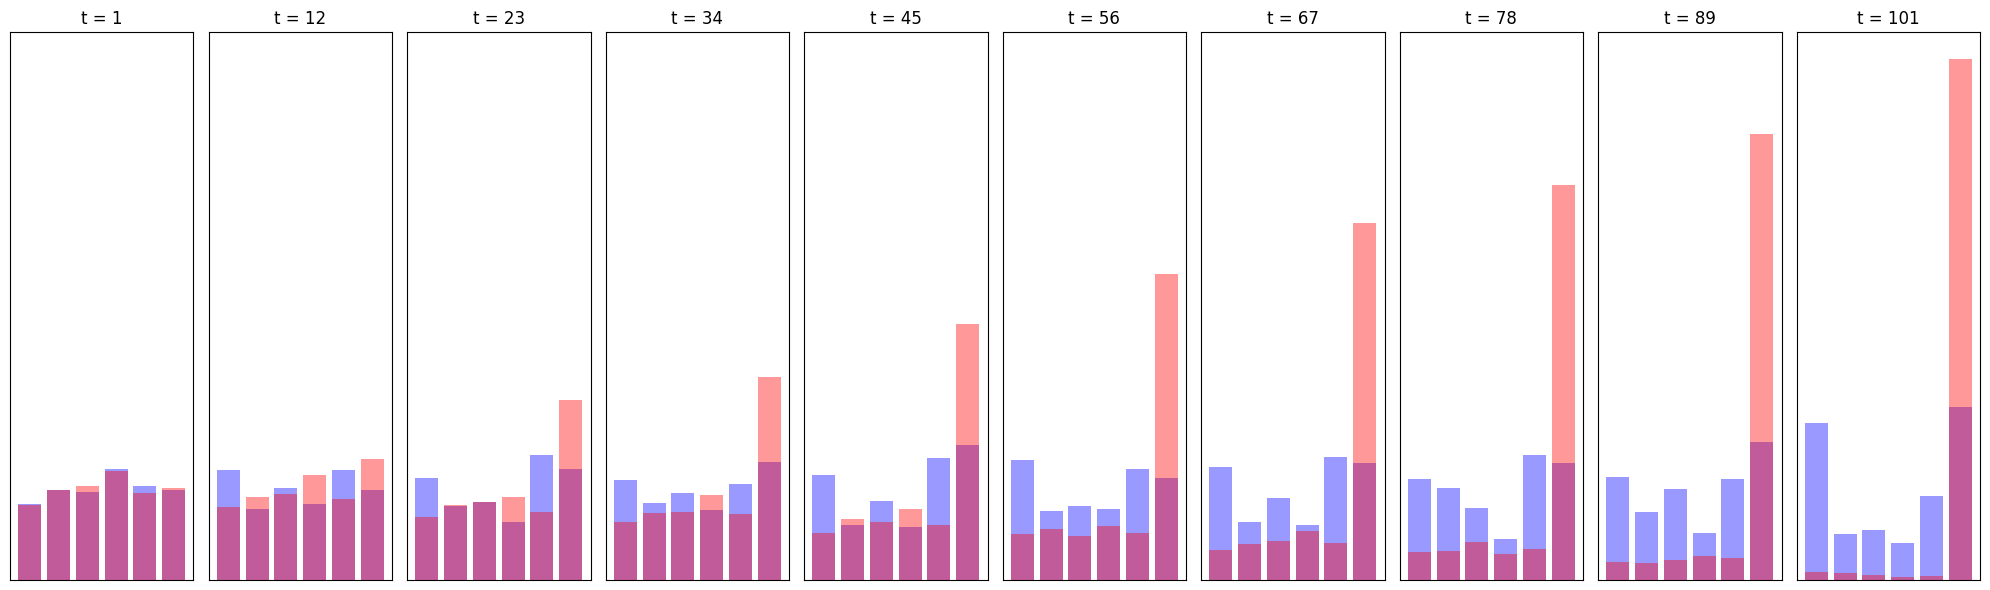

In [37]:
indices = plot_time_series_histograms(histograms_paths, conditional_histograms_paths, 10)

## Train

In [19]:
experiment_files = ExperimentFiles(experiment_name="prenzlauer_experiment",
                                   experiment_type="colors_1",
                                   experiment_indentifier=None)
crm.experiment_files = experiment_files

# ==================================================
# START OF TRAINING 
# ==================================================
# Current Model ************************************
colors_1
prenzlauer_experiment
None
# ==================================================
# Number of Epochs 100
# ==================================================


Epoch 100, Loss: 0.0001: 100%|██████████| 100/100 [02:58<00:00,  1.78s/it]
100it [00:00, 100.00it/s]
100it [00:00, 135.51it/s]


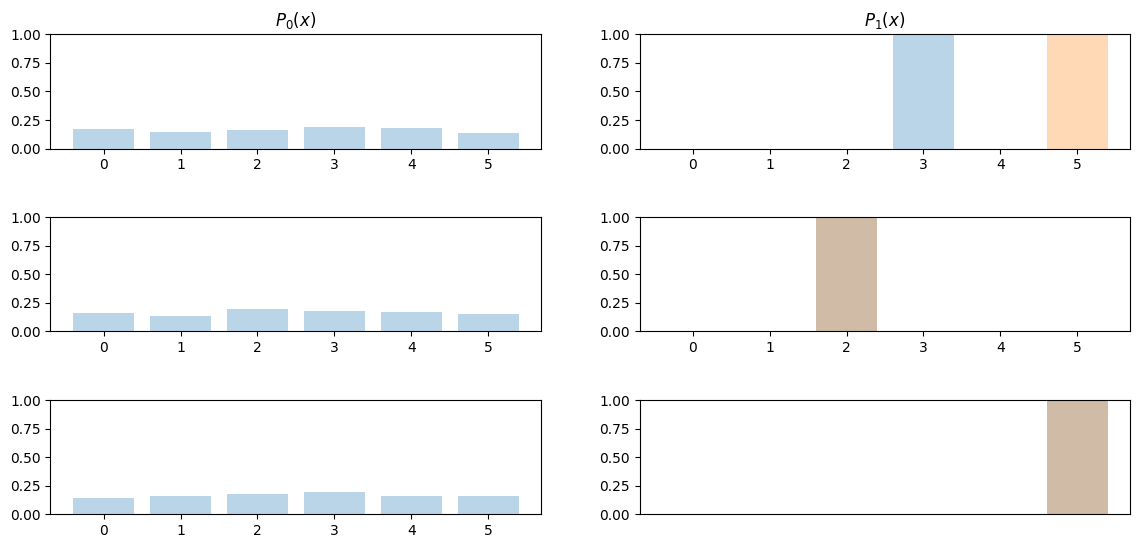

In [20]:
crm_trainer = CRMTrainer(config, experiment_files=experiment_files,crm=crm)
results_, all_metrics = crm_trainer.train()